In [6]:
# import kagglehub

# # Download latest version
# path = kagglehub.dataset_download("Microsoft/microsoft-security-incident-prediction")

# print("Path to dataset files:", path)

# https://www.kaggle.com/datasets/Microsoft/microsoft-security-incident-prediction
# https://arxiv.org/abs/2407.09017
# https://www.microsoft.com/en-us/research/publication/microsoft-security-incident-prediction/

In [47]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import time
import numpy as np

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, export_text
from sklearn.pipeline import Pipeline
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.metrics import accuracy_score, recall_score, precision_score, roc_curve, f1_score, confusion_matrix, classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.svm import SVC
from imblearn.metrics import specificity_score

from sklearn.ensemble import RandomForestClassifier


from plot_helpers import render_plot

pd.set_option('display.max_columns', None)

In [8]:
df_train = pd.read_csv('DATA/GUIDE_Train.csv')
df_test = pd.read_csv('DATA/GUIDE_Test.csv')

In [9]:
df_train.shape, df_test.shape

((100000, 45), (100000, 46))

In [10]:
# find the column that is different between the two data sets
set(df_train.columns).symmetric_difference(set(df_test.columns))

{'Usage'}

In [11]:
# explore the value within the Usage column in the test data set
df_test.Usage.value_counts()


Usage
Public     70405
Private    29595
Name: count, dtype: int64

In [12]:
# The usage columns is not present in the training data. And it appears to be a column that indicates how the data should be used. 
# We will drop this column from the test data set
df_test.drop(columns=['Usage'], inplace=True)

In [13]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 45 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   Id                  100000 non-null  int64  
 1   OrgId               100000 non-null  int64  
 2   IncidentId          100000 non-null  int64  
 3   AlertId             100000 non-null  int64  
 4   Timestamp           100000 non-null  object 
 5   DetectorId          100000 non-null  int64  
 6   AlertTitle          100000 non-null  int64  
 7   Category            100000 non-null  object 
 8   MitreTechniques     42504 non-null   object 
 9   IncidentGrade       99475 non-null   object 
 10  ActionGrouped       588 non-null     object 
 11  ActionGranular      588 non-null     object 
 12  EntityType          100000 non-null  object 
 13  EvidenceRole        100000 non-null  object 
 14  DeviceId            100000 non-null  int64  
 15  Sha256              100000 non-null

In [14]:
cat_columns = ['Category', 'EntityType', 'EvidenceRole', 'SuspicionLevel', 'LastVerdict',
               'ResourceType', 'Roles', 'AntispamDirection', 'ThreatFamily']

numerical_columns = ['DeviceId', 'Sha256', 'IpAddress', 'Url', 'AccountSid', 'AccountUpn', 'AccountObjectId',
                     'AccountName', 'DeviceName', 'NetworkMessageId', 'EmailClusterId', 'RegistryKey',
                     'RegistryValueName', 'RegistryValueData', 'ApplicationId', 'ApplicationName',
                     'OAuthApplicationId', 'FileName', 'FolderPath', 'ResourceIdName', 'OSFamily', 
                     'OSVersion', 'CountryCode', 'State', 'City']

drop_columns = []

In [15]:
# convert timestamp to datetime
df_train['Timestamp'] = pd.to_datetime(df_train['Timestamp'])
df_test['Timestamp'] = pd.to_datetime(df_test['Timestamp'])

# convert MitreTechniques to extract first technique
df_train['FirstMitreTechnique'] = df_train['MitreTechniques'].str.split(';').str[0]
df_test['FirstMitreTechnique'] = df_test['MitreTechniques'].str.split(';').str[0]

df_train['FirstMitreTechnique'] = df_train['FirstMitreTechnique'].str.split('.').str[0]
df_test['FirstMitreTechnique'] = df_test['FirstMitreTechnique'].str.split('.').str[0]

# add MitreColumns to be dropped later
drop_columns.append(['MitreTechniques'])

In [16]:
# Find null values in the dataset
null_values = df_train.isnull().sum()
print(null_values.sort_values(ascending=False))

# consider removing columns with more than 80% missing values
#drop_columns.extend(['ResourceType', 'ActionGrouped', 'ActionGranular', 'ThreatFamily', 'EmailClusterId', 'Roles'])
type(drop_columns)


ResourceType           99909
ActionGrouped          99412
ActionGranular         99412
ThreatFamily           99200
EmailClusterId         98984
AntispamDirection      98220
Roles                  97728
SuspicionLevel         84876
LastVerdict            76567
FirstMitreTechnique    57496
MitreTechniques        57496
IncidentGrade            525
RegistryValueName          0
OSFamily                   0
CountryCode                0
State                      0
ResourceIdName             0
FolderPath                 0
FileName                   0
City                       0
OAuthApplicationId         0
ApplicationName            0
ApplicationId              0
RegistryValueData          0
OSVersion                  0
Id                         0
RegistryKey                0
OrgId                      0
IncidentId                 0
AlertId                    0
Timestamp                  0
DetectorId                 0
AlertTitle                 0
Category                   0
EntityType    

list

<Axes: xlabel='IncidentGrade', ylabel='count'>

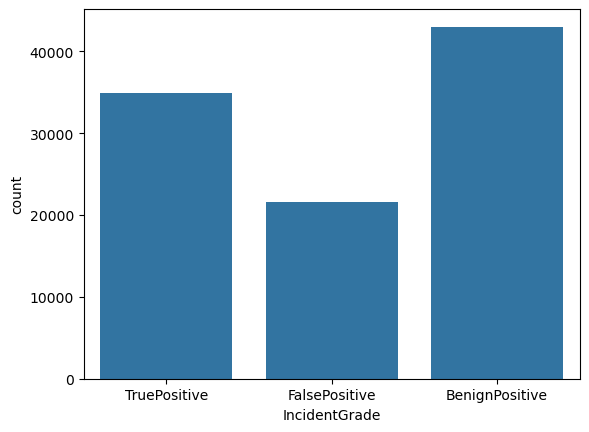

In [17]:
# Explore IncidentGrade
sns.countplot(x='IncidentGrade', data=df_train)

#### Fairly balanced classes

<Axes: xlabel='IncidentGrade', ylabel='count'>

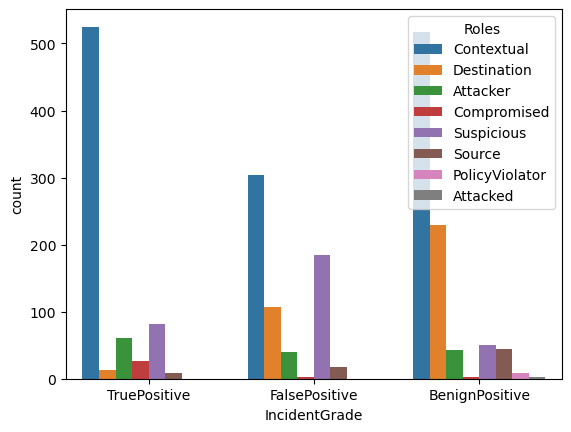

In [18]:
# Explore Roles with IncidentGrade
sns.countplot(x='IncidentGrade', hue='Roles', data=df_train)


In [19]:
# Find all incidents with duplicate AlertIds
duplicate_alerts = df_train[df_train.duplicated('AlertId', keep=False)]

# Show a few sample incidents that are marked true positive
duplicate_alerts[duplicate_alerts['IncidentGrade'] == 'TruePositive'].head(10)

,Id,OrgId,IncidentId,AlertId,Timestamp,DetectorId,AlertTitle,Category,MitreTechniques,IncidentGrade,ActionGrouped,ActionGranular,EntityType,EvidenceRole,DeviceId,Sha256,IpAddress,Url,AccountSid,AccountUpn,AccountObjectId,AccountName,DeviceName,NetworkMessageId,EmailClusterId,RegistryKey,RegistryValueName,RegistryValueData,ApplicationId,ApplicationName,OAuthApplicationId,ThreatFamily,FileName,FolderPath,ResourceIdName,ResourceType,Roles,OSFamily,OSVersion,AntispamDirection,SuspicionLevel,LastVerdict,CountryCode,State,City,FirstMitreTechnique
27,489626273557,0,211,160158,2024-06-11 08:26:58+00:00,0,0,InitialAccess,T1078;T1078.004,TruePositive,NaN,NaN,CloudLogonRequest,Related,98799,138268,360606,160396,441377,673934,425863,453297,153085,529644,NaN,1631,635,860,2251,3421,881,NaN,289573,117668,3586,NaN,NaN,5,66,NaN,NaN,NaN,242,1445,10630,T1078
51,1486058687146,8,5447,12744,2024-06-03 04:47:13+00:00,1,1,InitialAccess,T1566.002,TruePositive,NaN,NaN,User,Impacted,98799,138268,360606,160396,10365,8793,9959,10734,153085,529644,NaN,1631,635,860,2251,3421,881,NaN,289573,117668,3586,NaN,NaN,5,66,NaN,NaN,NaN,242,1445,10630,T1566
84,755914248188,24,71757,48212,2024-06-07 00:52:03+00:00,1,1,InitialAccess,T1566.002,TruePositive,NaN,NaN,MailCluster,Related,98799,138268,360606,160396,441377,673934,425863,453297,153085,529644,3.169483e+09,1631,635,860,2251,3421,881,NaN,289573,117668,3586,NaN,NaN,5,66,NaN,NaN,Malicious,242,1445,10630,T1566
100,352187320755,28,9445,27326,2024-06-14 14:28:47+00:00,1,1,InitialAccess,T1566.002,TruePositive,NaN,NaN,Mailbox,Impacted,98799,138268,360606,160396,87766,102627,100975,64996,153085,529644,NaN,1631,635,860,2251,3421,881,NaN,289573,117668,3586,NaN,NaN,5,66,NaN,NaN,NaN,242,1445,10630,T1566
114,670014901898,148,20,32531,2024-06-04 08:45:48+00:00,1264,13900,Exfiltration,NaN,TruePositive,NaN,NaN,File,Impacted,98799,36136,360606,160396,441377,673934,425863,453297,153085,529644,NaN,1631,635,860,2251,3421,881,NaN,60366,31161,3586,NaN,NaN,5,66,NaN,NaN,NaN,242,1445,10630,NaN
142,154618827802,1216,3333,14741,2024-06-11 15:57:54+00:00,10,8,InitialAccess,T1566.001,TruePositive,NaN,NaN,User,Impacted,98799,138268,360606,160396,135336,422162,137787,159335,153085,529644,NaN,1631,635,860,2251,3421,881,NaN,289573,117668,3586,NaN,NaN,5,66,NaN,NaN,NaN,242,1445,10630,T1566
176,1030792152892,0,294,178333,2024-06-07 08:44:15+00:00,4,3,InitialAccess,NaN,TruePositive,NaN,NaN,User,Impacted,98799,138268,360606,160396,163,233,155,186,153085,529644,NaN,1631,635,860,2251,3421,881,NaN,289573,117668,3586,NaN,NaN,5,66,NaN,NaN,NaN,242,1445,10630,NaN
220,927712937952,19,679,2186,2024-06-08 14:13:52+00:00,23,16,CommandAndControl,NaN,TruePositive,NaN,NaN,Url,Related,98799,138268,360606,265,441377,673934,425863,453297,153085,529644,NaN,1631,635,860,2251,3421,881,NaN,289573,117668,3586,NaN,NaN,5,66,NaN,NaN,NaN,242,1445,10630,NaN
235,790273983142,22,145,378952,2024-06-05 13:44:01+00:00,0,0,InitialAccess,T1078;T1078.004,TruePositive,NaN,NaN,User,Impacted,98799,138268,360606,160396,213,302,204,238,153085,529644,NaN,1631,635,860,2251,3421,881,NaN,289573,117668,3586,NaN,NaN,5,66,NaN,NaN,NaN,242,1445,10630,T1078
266,652835030879,0,95,409298,2024-06-09 11:25:08+00:00,0,0,InitialAccess,T1078;T1078.004,TruePositive,NaN,NaN,CloudLogonRequest,Related,98799,138268,360606,160396,441377,673934,425863,453297,153085,529644,NaN,1631,635,860,2251,3421,881,NaN,289573,117668,3586,NaN,NaN,5,66,NaN,NaN,NaN,242,1445,10630,T1078


In [20]:
# for the ratio of Category, and show top 10 categories of alerts
df_train['Category'].value_counts(normalize=True).sort_values(ascending=False).head(10)*100

Category
InitialAccess         45.273
Exfiltration          16.556
SuspiciousActivity    10.528
CommandAndControl      8.694
Impact                 7.950
CredentialAccess       3.017
Execution              2.840
Malware                1.516
Discovery              1.394
Persistence            0.708
Name: proportion, dtype: float64

#### Top categories for logging Incidents and Alerts are InitialAccess, Exfiltration, SuspiciousActivity, CommandA8dControl

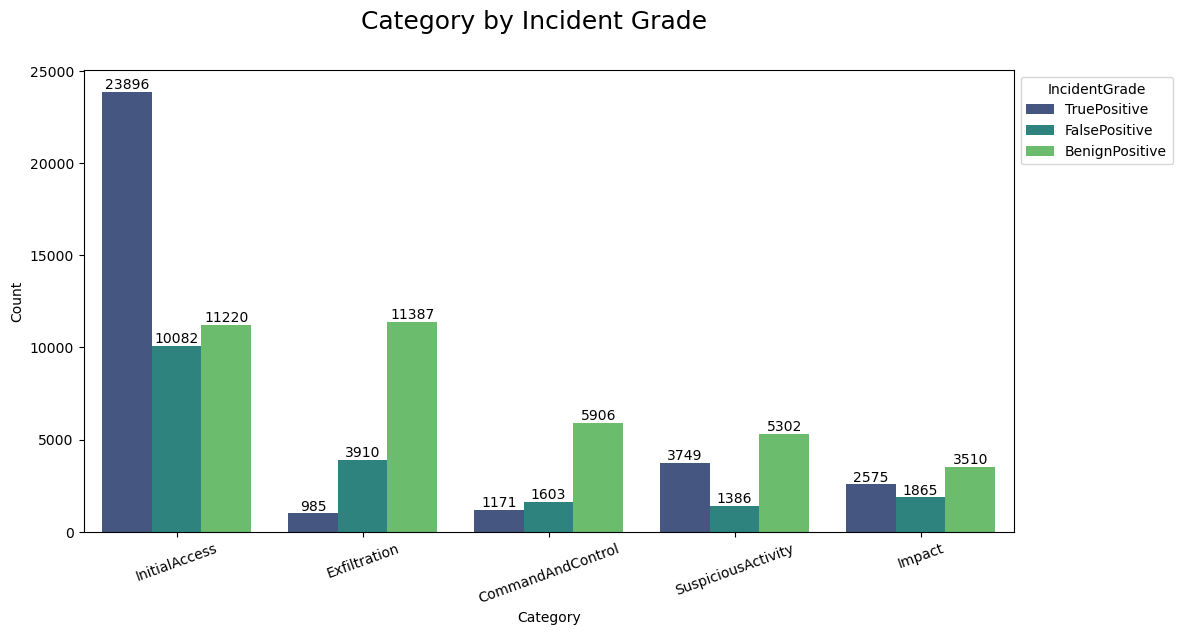

In [21]:
# plot top 5 categories with incident grade

plt.figure(figsize=(12, 6))
top_10_categories = df_train['Category'].value_counts().head(5).index
ax = sns.countplot(data=df_train[df_train['Category'].isin(top_10_categories)], x='Category', hue='IncidentGrade', palette='viridis')

render_plot(ax, heading='Category by Incident Grade', xlabel='Category', ylabel='Count')


#### Exfiltration attemps appear to be last harmful compared to alerts marked as Initial Access, Suspicious or Impact

#### Last Verdict
https://learn.microsoft.com/en-us/defender-xdr/m365d-remediation-actions

In [22]:
# explore the values within LastVerdict
print(df_train['LastVerdict'].value_counts())

# remove LastVerdict values that begin with 'Domain'
df_last_verdict = df_train[~df_train['LastVerdict'].str.startswith('Domain', na=False)]

LastVerdict
Suspicious        14712
Malicious          4528
NoThreatsFound     4193
Name: count, dtype: int64


In [23]:
# Summarize LastVerdict
print('Number of missing values in Last Verdict are: ', df_last_verdict['LastVerdict'].isna().sum()  )

Number of missing values in Last Verdict are:  76567


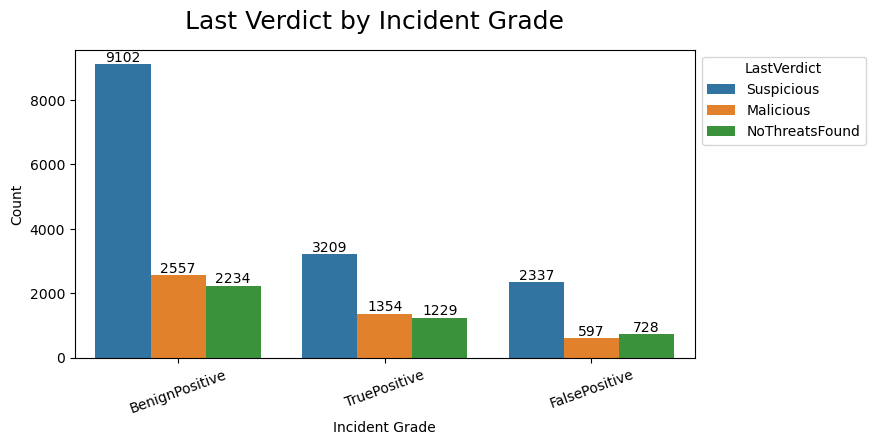

In [24]:
# plot LastVerdict by Incident Grade
plt.figure(figsize=(8, 4))
ax = sns.countplot(data=df_last_verdict, x='IncidentGrade', hue='LastVerdict', order=df_last_verdict['IncidentGrade'].value_counts().index)

render_plot(ax, heading='Last Verdict by Incident Grade', xlabel='Incident Grade', ylabel='Count')


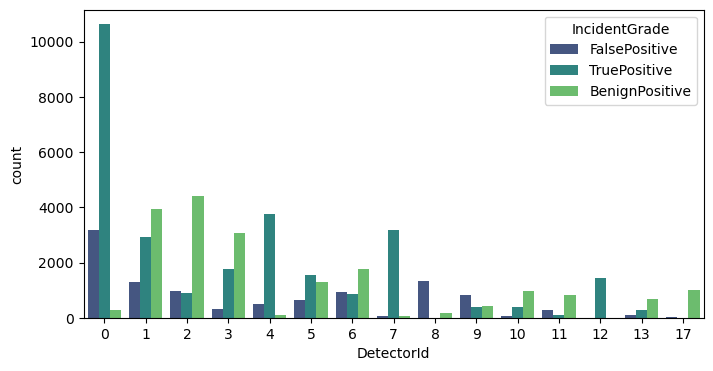

In [25]:
# plot top 10 Detectors by Incident Grade
plt.figure(figsize=(8, 4))
top_10_detectors = df_train['DetectorId'].value_counts().head(15).index
ax = sns.countplot(data=df_train[df_train['DetectorId'].isin(top_10_detectors)], x='DetectorId', hue='IncidentGrade', palette='viridis')

In [26]:
# "DetectorId 0" typically refers to a generic or default detection mechanism, meaning it signifies an alert triggered by a broad security
# rule that isn't specifically tied to a particular security feature or detection method within the XDR platform; it usually indicates a 
# high-level threat that needs further investigation to pinpoint the exact source of the suspicious activity

# check the entity type for DetectorId = 0
df_train[df_train['DetectorId'] == 0]['EntityType'].value_counts()

EntityType
User                 4064
CloudLogonRequest    4000
Ip                   3983
CloudLogonSession    2044
Name: count, dtype: int64

### EntityTypes
https://learn.microsoft.com/en-us/azure/sentinel/entities-reference

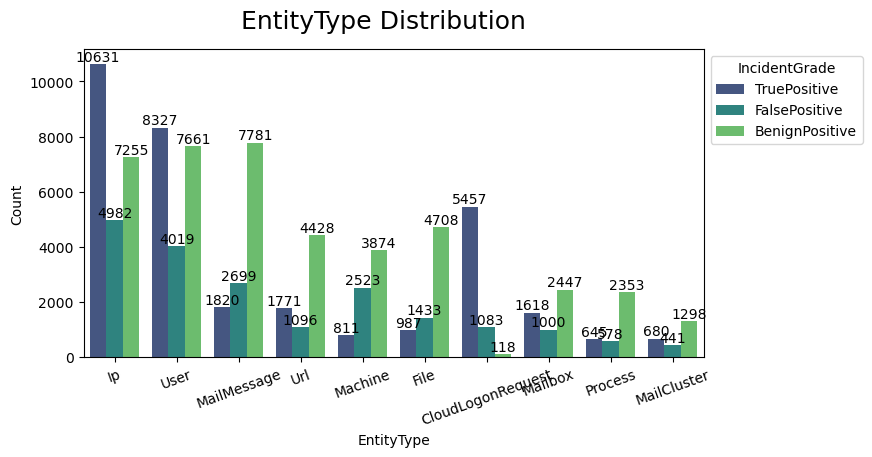

In [27]:
# check the distribution of EntityTypes
plt.figure(figsize=(8, 4))
ax = sns.countplot(data=df_train, x='EntityType', hue='IncidentGrade', order=df_train['EntityType'].value_counts().head(10).index, palette='viridis')
render_plot(ax, heading='EntityType Distribution', xlabel='EntityType', ylabel='Count')


In [28]:
# Explore IncidentId 5447

# df_train[df_train['IncidentId'] == 5447]

In [29]:
#"evidencerole" refers to the specific part a particular piece of evidence plays within a security alert, indicating whether 
# it is the primary target of the attack, a related component, or simply provides supporting context for the incident; 
# essentially, it describes how the evidence is involved in the overall threat scenario

df_train.groupby(['IncidentGrade', 'EvidenceRole']).size().sort_values(ascending=False)  

IncidentGrade   EvidenceRole
TruePositive    Related         22847
BenignPositive  Impacted        22566
                Related         20458
TruePositive    Impacted        12040
FalsePositive   Related         11285
                Impacted        10279
dtype: int64

#### MitreTechniques
https://attack.mitre.org/

In [30]:
df_grouped = df_train.groupby(['IncidentGrade','FirstMitreTechnique']).size().reset_index(name='size')
df_sorted = df_grouped.sort_values(by='size', ascending=False)
df_sorted

,IncidentGrade,FirstMitreTechnique,size
214,TruePositive,T1078,10750
103,BenignPositive,T1566,8731
243,TruePositive,T1566,4973
146,FalsePositive,T1078,3403
187,FalsePositive,T1566,3252
...,...,...,...
73,BenignPositive,T1484,1
81,BenignPositive,T1499,1
83,BenignPositive,T1525,1
181,FalsePositive,T1548,1


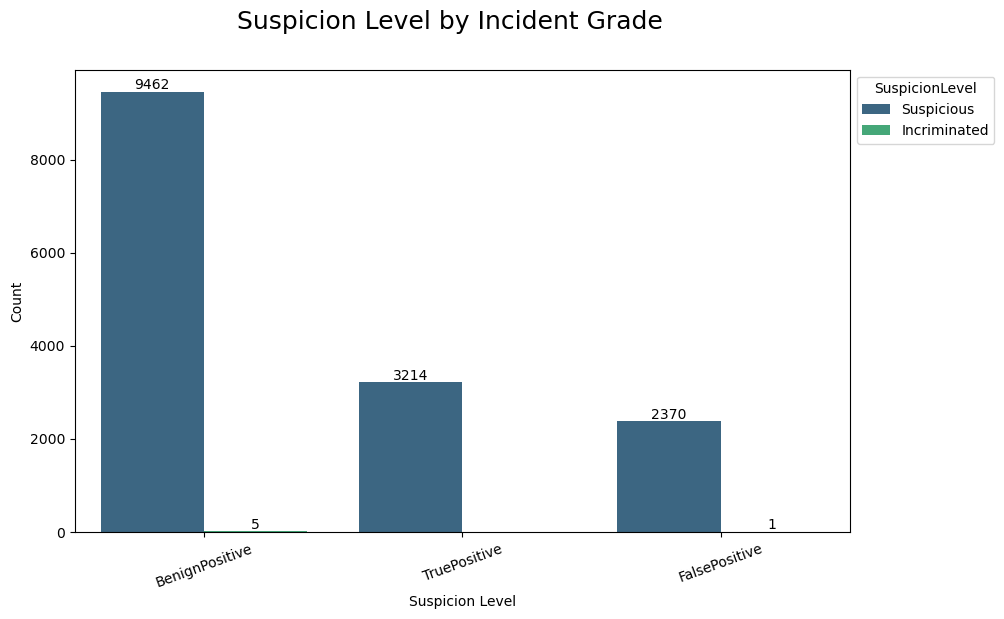

In [31]:
# "suspicion level" refers to the degree of confidence that a detected activity is potentially malicious, 
# often indicated by a "suspicious" verdict within an alert, meaning the system believes there is a high likelihood of a threat 
# but further investigation is needed before taking definitive action; this level can be considered as a 
# middle ground between "clean" (not malicious) and "malicious" (confirmed threat)

# Explore SuspicionLevel feature along with IncidentGrade

# Plot SuspicionLevel with IncidentGrade
plt.figure(figsize=(10, 6))
ax = sns.countplot(data=df_train, x='IncidentGrade', hue='SuspicionLevel', palette='viridis', order=df_train['IncidentGrade'].value_counts().index)
render_plot(ax, heading='Suspicion Level by Incident Grade', xlabel='Suspicion Level', ylabel='Count')



### EDA Numerical Data

In [32]:
# Add a numerical feature for IncidentGrade
df_train['IncidentGradeNum'] = df_train['IncidentGrade'].map({'TruePositive': 1, 'FalsePositive': -1, 'BenignPositive': 0})

In [33]:
df_train['IncidentGradeNum'].value_counts()

IncidentGradeNum
 0.0    43024
 1.0    34887
-1.0    21564
Name: count, dtype: int64

In [34]:
# Analyze Geographical Features

num_features_geo = ['CountryCode', 'State', 'City', 'IncidentGradeNum']

# Top 10 countries by Incident Grade
top_10_countries = df_train['CountryCode'].value_counts().head(10)
print(top_10_countries)

# Top 10 countries/state/city by Incident Grade
top_10_country_states = df_train.groupby(['CountryCode', 'State', 'City']).size().reset_index(name='size').sort_values(by='size', ascending=False).head(10)
top_10_country_states

CountryCode
242    92087
0       1848
1       1180
2        589
4        438
3        358
5        314
6        241
7        223
8        167
Name: count, dtype: int64


,CountryCode,State,City,size
942,242,1445,10630,92084
321,1,0,0,1138
465,5,1445,10630,313
0,0,1,1,236
334,2,2,2,220
512,10,7,4,140
495,7,8,6,133
320,0,1445,10630,131
1,0,1,5,130
505,8,10,7,110


#### Alerts/Incidents by City/state/country
Most alerts/incidents appear to be generated from the same location. 

<Axes: >

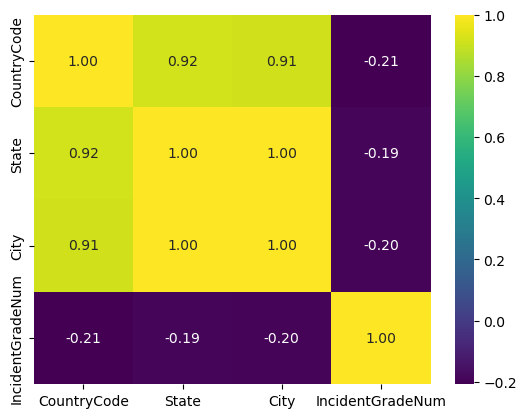

In [35]:
sns.heatmap(df_train[num_features_geo].corr(), annot=True, cmap='viridis', fmt=".2f")

<Axes: >

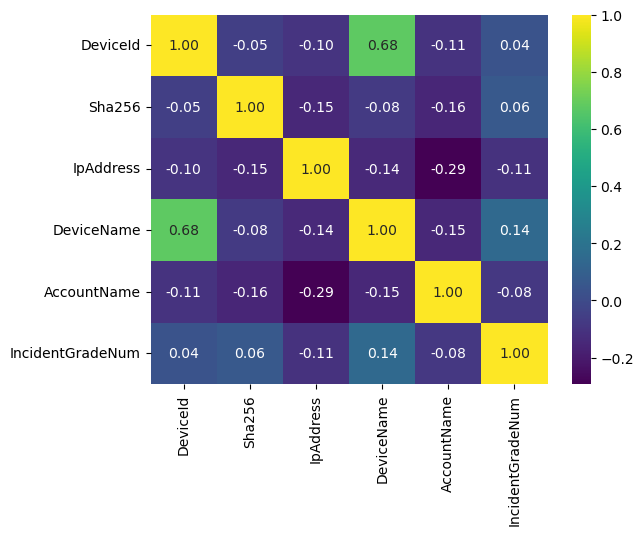

In [36]:
num_features_device = ['DeviceId', 'Sha256', 'IpAddress', 'DeviceName', 'AccountName', 'IncidentGradeNum']

sns.heatmap(df_train[num_features_device].corr(), annot=True, cmap='viridis', fmt=".2f")

<Axes: >

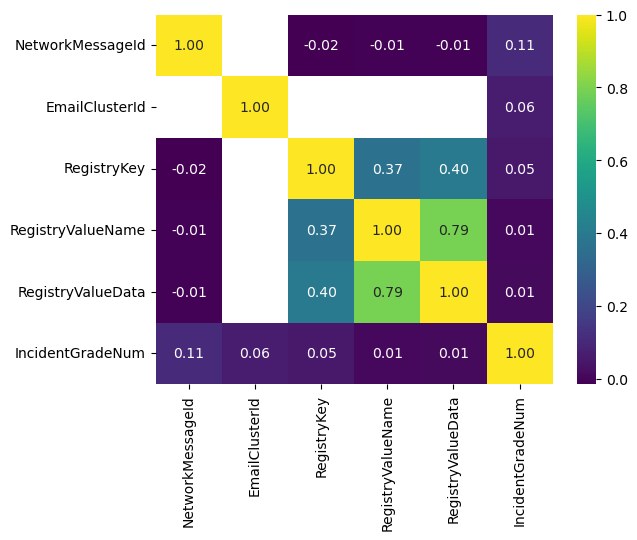

In [37]:
num_features_infr = ['NetworkMessageId', 'EmailClusterId', 'RegistryKey', 'RegistryValueName', 'RegistryValueData', 'IncidentGradeNum']
sns.heatmap(df_train[num_features_infr].corr(), annot=True, cmap='viridis', fmt=".2f")

#### Weak correlation between IncidentGrade and Numerical Features

### Data Clean Up   

In [38]:
# Drop Columns marked in the EDA section

print('Columns to be dropped: ', drop_columns[0])  

df_train.drop(columns=drop_columns[0], axis=1, inplace=True)
df_test.drop(columns=drop_columns[0], axis=1, inplace=True)

Columns to be dropped:  ['MitreTechniques']


### Train/Test Split

In [67]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 46 columns):
 #   Column               Non-Null Count   Dtype              
---  ------               --------------   -----              
 0   Id                   100000 non-null  int64              
 1   OrgId                100000 non-null  int64              
 2   IncidentId           100000 non-null  int64              
 3   AlertId              100000 non-null  int64              
 4   Timestamp            100000 non-null  datetime64[ns, UTC]
 5   DetectorId           100000 non-null  int64              
 6   AlertTitle           100000 non-null  int64              
 7   Category             100000 non-null  object             
 8   IncidentGrade        99475 non-null   object             
 9   ActionGrouped        588 non-null     object             
 10  ActionGranular       588 non-null     object             
 11  EntityType           100000 non-null  object             
 12  Evi

In [74]:
from scipy.sparse import hstack, csr_matrix

# Drop 
# X_train = df_train.drop(columns = ['IncidentGrade'])  
# y_train = df_train['IncidentGrade']

# X_test = df_test.drop(columns = ['IncidentGrade'])  

# categorical columns
ohe = OneHotEncoder(handle_unknown='ignore', )
ohe.fit(df_train[cat_columns])

X_train_ohe = ohe.transform(df_train[cat_columns])
X_test_ohe = ohe.transform(df_test[cat_columns])
X_train_data_numerical = csr_matrix(df_train[numerical_columns].fillna(-1).values)
X_test_data_numerical = csr_matrix(df_test[numerical_columns].fillna(-1).values)

X_train = hstack([X_train_ohe, X_train_data_numerical])
X_test = hstack([X_test_ohe, X_test_data_numerical])

le = LabelEncoder()
le.fit(df_train['IncidentGrade'])

y_train = le.transform(df_train['IncidentGrade'])
y_test = le.transform(df_test['IncidentGrade'])


### Basic Classifiers

### Decision Tree

In [75]:
model = DecisionTreeClassifier(random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

In [76]:
accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred, average='macro')
precision = precision_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')

print('Accuracy: {}'.format(accuracy))
print('Macro-Precision: {}'.format(precision))
print('Macro-Recall: {}'.format(recall))
print('Macro-F1 Score: {}'.format(f1))

Accuracy: 0.67467
Macro-Precision: 0.49081374177254383
Macro-Recall: 0.48456011364357304
Macro-F1 Score: 0.4870095284259957


/opt/anaconda3/envs/BerkeleyAIML/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [77]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.70      0.72      0.71     42352
           1       0.55      0.48      0.51     21612
           2       0.71      0.74      0.72     36036
           3       0.00      0.00      0.00         0

    accuracy                           0.67    100000
   macro avg       0.49      0.48      0.49    100000
weighted avg       0.67      0.67      0.67    100000



/opt/anaconda3/envs/BerkeleyAIML/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/BerkeleyAIML/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/BerkeleyAIML/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
